## Project: using LSTM with various regularization techniques to model and predict temperature time series 

We consider observations of temperature (in Celsius) measured every 10 minutes in Jena, Germany between January 2009 and January 2017. The dataset is availible at https://www.bgc-jena.mpg.de/wetter/.

In this simple project, the goal is to practice time series modelling by training a LSTM network with various combinations of activation functions and regularization techniques. I especially want to try out the early stopping technique. (More techniques will be tried out in the future.)

We get our training set by chopping up the entire series into multiple pieces. For each piece, the latest temperature is treated as response and the rest of temperatures are input variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas import DataFrame
from pandas import concat

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [2]:
df = pd.read_csv('C:/Users/Hanning Su/Desktop/Time Series Analysis with Python/Final/jena_climate_2009_2016.csv',parse_dates=True,index_col='Date Time')
xt = df['T (degC)']
xt = xt.reset_index(drop=True)
display(df.head())
display(df.tail())
xt.tail()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2016-12-31 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
2016-12-31 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
2016-12-31 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
2016-12-31 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
2017-01-01 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


420546   -4.05
420547   -3.35
420548   -3.16
420549   -4.23
420550   -4.82
Name: T (degC), dtype: float64

In [3]:
# missing values
print(df.shape)
df.isnull().sum()

(420551, 14)


p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [4]:
n_timesteps = 34

features_set = []
labels = []
for i in range(n_timesteps, xt.shape[0]):
    features_set.append(xt[i-n_timesteps:i])
    labels.append(xt[i])
    
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set,(features_set.shape[0], features_set.shape[1], 1))

In [5]:
print("features_set.shape is ", features_set.shape)
print("labels.shape is ", labels.shape)

features_set.shape is  (420517, 34, 1)
labels.shape is  (420517,)


In [6]:
# split into train and test sets
n = features_set.shape[0]
n_train = int(n * 0.90)
n_test = n - n_train
#print("n_train = ",str(n_train))
#print("n_test = ",str(n_test))

features_set_train, features_set_test =  features_set[0:n_train,:,:], features_set[n_train:n,:,:]
labels_train, labels_test =  labels[0:n_train], labels[n_train:n]

print("features_set_train.shape is ", features_set_train.shape)
print("labels_train.shape is ", labels_train.shape)
print("\nfeatures_set_test.shape is ", features_set_test.shape)
print("labels_test.shape is ", labels_test.shape)

features_set_train.shape is  (378465, 34, 1)
labels_train.shape is  (378465,)

features_set_test.shape is  (42052, 34, 1)
labels_test.shape is  (42052,)


In [7]:
print("2 first features:")
display(features_set_train[0:2,:,0])
print("2 first labels:")
display(labels_train[0:2]) # the observation at time 15 and 16 basically

2 first features:


array([[-8.02, -8.41, -8.51, -8.31, -8.27, -8.05, -7.62, -7.62, -7.91,
        -8.43, -8.76, -8.88, -8.85, -8.83, -8.66, -8.66, -8.7 , -8.81,
        -8.84, -8.94, -8.94, -8.86, -8.99, -9.05, -9.23, -9.49, -9.5 ,
        -9.35, -9.47, -9.63, -9.67, -9.68, -9.9 , -9.91],
       [-8.41, -8.51, -8.31, -8.27, -8.05, -7.62, -7.62, -7.91, -8.43,
        -8.76, -8.88, -8.85, -8.83, -8.66, -8.66, -8.7 , -8.81, -8.84,
        -8.94, -8.94, -8.86, -8.99, -9.05, -9.23, -9.49, -9.5 , -9.35,
        -9.47, -9.63, -9.67, -9.68, -9.9 , -9.91, -9.51]])

2 first labels:


array([-9.51, -9.67])

We proceed by trying out various combination of activation functions and regularization techniques. Early stopping is used in some cases: training will stop when the validation loss fails to improve for 3 consecutive epochs.

| Model | activation |  regularization | early stopping? |
| --- | --- | --- | --- |
| 0 | relu | dropout | yes
| 1 | elu | dropout | yes
| 2 | tanh | dropout | no
| 3 | elu | dropout + L1 | no
| 4 | elu | dropout + L2 | no
| 5 | tanh | L2 | yes

In [9]:
n_features = 1

model = models.Sequential()
model.add(layers.SimpleRNN(10, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='linear'))  # produce output

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [11]:
callback = EarlyStopping(monitor="val_loss", patience=3)
# This callback will stop the training when there is no improvement in  
# the validation loss for three consecutive epochs. 

nepochs = 40
model.compile(optimizer='adam',
              loss='mse')
history = model.fit(features_set_train, labels_train,
          epochs=nepochs,
          batch_size=32,
          callbacks=[callback],
          validation_data=(features_set_test, labels_test))
history_rnn = history.history

Epoch 1/40
11828/11828 [==============================] - 53s 4ms/step - loss: 8.8400 - val_loss: 0.2695
Epoch 2/40
11828/11828 [==============================] - 57s 5ms/step - loss: 6.4408 - val_loss: 0.4561
Epoch 3/40
11828/11828 [==============================] - 54s 5ms/step - loss: 5.8399 - val_loss: 0.2687
Epoch 4/40
11828/11828 [==============================] - 53s 4ms/step - loss: 5.8340 - val_loss: 0.3186
Epoch 5/40
11828/11828 [==============================] - 53s 4ms/step - loss: 5.8953 - val_loss: 0.5688
Epoch 6/40
11828/11828 [==============================] - 52s 4ms/step - loss: 5.8002 - val_loss: 0.4568


In [16]:
model1 = models.Sequential()
model1.add(layers.SimpleRNN(10, activation='elu', input_shape=(n_timesteps,n_features)))
model1.add(Dropout(0.2))
model1.add(layers.Dense(1, activation='linear'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [17]:
callback = EarlyStopping(monitor='val_loss', patience=3) 

nepochs = 40

model1.compile(optimizer='adam',
              loss='mse')
history1 = model1.fit(features_set_train, labels_train,
          epochs=nepochs,
          batch_size=32,
          callbacks=[callback],
          validation_data=(features_set_test, labels_test))
history_rnn1 = history1.history

Epoch 1/40
11828/11828 [==============================] - 53s 5ms/step - loss: 4.7387 - val_loss: 0.1908
Epoch 2/40
11828/11828 [==============================] - 49s 4ms/step - loss: 2.4533 - val_loss: 0.0892
Epoch 3/40
11828/11828 [==============================] - 54s 5ms/step - loss: 2.1266 - val_loss: 0.0990
Epoch 4/40
11828/11828 [==============================] - 47s 4ms/step - loss: 1.9683 - val_loss: 0.0660
Epoch 5/40
11828/11828 [==============================] - 47s 4ms/step - loss: 1.8969 - val_loss: 0.1993
Epoch 6/40
11828/11828 [==============================] - 47s 4ms/step - loss: 1.8965 - val_loss: 0.0945
Epoch 7/40
11828/11828 [==============================] - 48s 4ms/step - loss: 1.8759 - val_loss: 0.0962


In [20]:
model2 = models.Sequential()
model2.add(layers.SimpleRNN(10, activation='tanh', input_shape=(n_timesteps,n_features)))
model2.add(Dropout(0.2))
model2.add(layers.Dense(1, activation='linear'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [21]:
model2.compile(optimizer='adam',
              loss='mse')
history2 = model2.fit(features_set_train, labels_train,
          epochs=nepochs,
          batch_size=32,
          validation_data=(features_set_test, labels_test))
history_rnn2 = history2.history

Epoch 1/40
11828/11828 [==============================] - 54s 5ms/step - loss: 11.8239 - val_loss: 0.1643
Epoch 2/40
11828/11828 [==============================] - 50s 4ms/step - loss: 2.1090 - val_loss: 0.1072
Epoch 3/40
11828/11828 [==============================] - 51s 4ms/step - loss: 1.8894 - val_loss: 0.1698
Epoch 4/40
11828/11828 [==============================] - 54s 5ms/step - loss: 1.8683 - val_loss: 0.1105
Epoch 5/40
11828/11828 [==============================] - 54s 5ms/step - loss: 1.8618 - val_loss: 0.0814
Epoch 6/40
11828/11828 [==============================] - 52s 4ms/step - loss: 1.8695 - val_loss: 0.2087
Epoch 7/40
11828/11828 [==============================] - 51s 4ms/step - loss: 1.8371 - val_loss: 0.0751
Epoch 8/40
11828/11828 [==============================] - 53s 5ms/step - loss: 1.8511 - val_loss: 0.3999
Epoch 9/40
11828/11828 [==============================] - 52s 4ms/step - loss: 1.8553 - val_loss: 0.0936
Epoch 10/40
11828/11828 [=============================

In [24]:
lam = 0.0001

model3 = models.Sequential()
model3.add(layers.SimpleRNN(10, kernel_regularizer=regularizers.l1(lam), activation='elu', input_shape=(n_timesteps,n_features)))
model3.add(Dropout(0.2))
model3.add(layers.Dense(1, activation='linear'))

model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [25]:
model3.compile(optimizer='adam',
              loss='mse')
history3 = model3.fit(features_set_train, labels_train,
          epochs=nepochs,
          batch_size=32,
          validation_data=(features_set_test, labels_test))
history_rnn3 = history3.history

Epoch 1/40
11828/11828 [==============================] - 67s 6ms/step - loss: 5.2843 - val_loss: 0.1130
Epoch 2/40
11828/11828 [==============================] - 55s 5ms/step - loss: 2.3476 - val_loss: 0.0743
Epoch 3/40
11828/11828 [==============================] - 52s 4ms/step - loss: 1.9983 - val_loss: 0.0917
Epoch 4/40
11828/11828 [==============================] - 48s 4ms/step - loss: 1.9064 - val_loss: 0.1195
Epoch 5/40
11828/11828 [==============================] - 49s 4ms/step - loss: 1.8828 - val_loss: 0.1103
Epoch 6/40
11828/11828 [==============================] - 52s 4ms/step - loss: 1.8644 - val_loss: 0.1240
Epoch 7/40
11828/11828 [==============================] - 52s 4ms/step - loss: 1.8651 - val_loss: 0.0781
Epoch 8/40
11828/11828 [==============================] - 52s 4ms/step - loss: 1.8626 - val_loss: 0.1453
Epoch 9/40
11828/11828 [==============================] - 49s 4ms/step - loss: 1.8446 - val_loss: 0.1567
Epoch 10/40
11828/11828 [==============================

In [27]:
lam = 0.0001

model4 = models.Sequential()
model4.add(layers.SimpleRNN(10, kernel_regularizer=regularizers.l2(lam), activation='elu', input_shape=(n_timesteps,n_features)))
model4.add(Dropout(0.2))
model4.add(layers.Dense(1, activation='linear'))

model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [28]:
model4.compile(optimizer='adam',
              loss='mse')
history4 = model4.fit(features_set_train, labels_train,
          epochs=nepochs,
          batch_size=32,
          validation_data=(features_set_test, labels_test))
history_rnn4 = history4.history

Epoch 1/40
11828/11828 [==============================] - 58s 5ms/step - loss: 4.5699 - val_loss: 0.1167
Epoch 2/40
11828/11828 [==============================] - 53s 4ms/step - loss: 2.4415 - val_loss: 0.2925
Epoch 3/40
11828/11828 [==============================] - 53s 4ms/step - loss: 2.1247 - val_loss: 0.1028
Epoch 4/40
11828/11828 [==============================] - 50s 4ms/step - loss: 2.0033 - val_loss: 0.0885
Epoch 5/40
11828/11828 [==============================] - 52s 4ms/step - loss: 1.9479 - val_loss: 0.2138
Epoch 6/40
11828/11828 [==============================] - 49s 4ms/step - loss: 1.8933 - val_loss: 0.1017
Epoch 7/40
11828/11828 [==============================] - 49s 4ms/step - loss: 1.8780 - val_loss: 0.1806
Epoch 8/40
11828/11828 [==============================] - 49s 4ms/step - loss: 1.8597 - val_loss: 0.1484
Epoch 9/40
11828/11828 [==============================] - 50s 4ms/step - loss: 1.8564 - val_loss: 0.0938
Epoch 10/40
11828/11828 [==============================

In [29]:
lam = 0.0001

model5 = models.Sequential()
model5.add(layers.SimpleRNN(10, kernel_regularizer=regularizers.l2(lam), activation='tanh', input_shape=(n_timesteps,n_features)))
model5.add(layers.Dense(1, activation='linear'))

model5.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [30]:
callback = EarlyStopping(monitor='val_loss', patience=3) 

nepochs = 40

model5.compile(optimizer='adam',
              loss='mse')
history5 = model5.fit(features_set_train, labels_train,
          epochs=nepochs,
          batch_size=32,
          callbacks=[callback],
          validation_data=(features_set_test, labels_test))
history_rnn5 = history5.history

Epoch 1/40
11828/11828 [==============================] - 56s 5ms/step - loss: 7.7794 - val_loss: 0.1011
Epoch 2/40
11828/11828 [==============================] - 53s 4ms/step - loss: 0.0679 - val_loss: 0.0534
Epoch 3/40
11828/11828 [==============================] - 60s 5ms/step - loss: 0.0484 - val_loss: 0.0485
Epoch 4/40
11828/11828 [==============================] - 55s 5ms/step - loss: 0.0466 - val_loss: 0.0484
Epoch 5/40
11828/11828 [==============================] - 52s 4ms/step - loss: 0.0462 - val_loss: 0.0489
Epoch 6/40
11828/11828 [==============================] - 52s 4ms/step - loss: 0.0460 - val_loss: 0.0597
Epoch 7/40
11828/11828 [==============================] - 52s 4ms/step - loss: 0.0458 - val_loss: 0.0483
Epoch 8/40
11828/11828 [==============================] - 53s 4ms/step - loss: 0.0455 - val_loss: 0.0472
Epoch 9/40
11828/11828 [==============================] - 55s 5ms/step - loss: 0.0456 - val_loss: 0.0472
Epoch 10/40
11828/11828 [==============================

It turns out that our last model give best performance: it has lowest minimum test MSE and lowest MSE at the end of training. We thus proceed with model 5.

Please plot the last 1440 observations of temperature (10 days) along with fitted values. Add  144 forecasted values (1 day) to the same plot. Make sure to add an appropriate title, x- and y-labels, and legend to differentiate between observed, fitted, and forecasted values.

In [31]:
xhat = model5.predict(features_set)
xhat

array([[-9.8390465],
       [-9.223932 ],
       [-9.76844  ],
       ...,
       [-3.0172496],
       [-3.085093 ],
       [-4.730851 ]], dtype=float32)

In [65]:
counter = 0
for i in range(n_timesteps, n_timesteps+144):
    forecast[i] = model5.predict(np.reshape(forecast[counter:counter+n_timesteps], (1, 34, 1)))
    counter += 1

In [66]:
forecast

array([-1.28      , -1.67      , -1.25      , -1.03      , -0.98      ,
       -1.4       , -1.47      , -1.61      , -1.65      , -1.52      ,
       -1.4       , -2.15      , -3.19      , -3.3       , -3.46      ,
       -3.09      , -2.75      , -2.61      , -2.51      , -2.48      ,
       -2.48      , -2.59      , -2.89      , -3.22      , -4.08      ,
       -4.45      , -4.09      , -3.76      , -3.93      , -4.05      ,
       -3.35      , -3.16      , -4.23      , -4.82      , -5.06026697,
       -5.2244916 , -5.37456846, -5.49399042, -5.58570719, -5.65329695,
       -5.69973993, -5.72778749, -5.73988771, -5.73823309, -5.72478914,
       -5.70131445, -5.6693759 , -5.63036203, -5.58550501, -5.53588724,
       -5.48245573, -5.42604399, -5.36736441, -5.30704355, -5.24561548,
       -5.18354082, -5.12120771, -5.05894613, -4.99703455, -4.93569994,
       -4.87512922, -4.81547689, -4.75686312, -4.69937944, -4.64309549,
       -4.58806086, -4.534307  , -4.4818511 , -4.43069458, -4.38

#### Plot the last 1440 observations of temperature (10 days) along with fitted values and add 144 forecasted values (1 day) to the same plot.

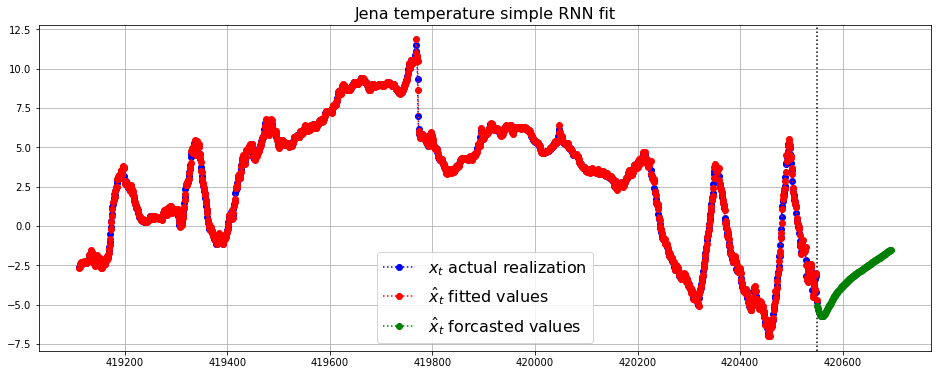

In [74]:
window = np.arange(len(xt)-1440,len(xt))
window_forecast = np.arange(len(xt), len(xt) + 144)

plt.figure(figsize=(16,6))
plt.title("Jena temperature simple RNN fit",fontsize=16)

plt.axvline(x=len(xt)-1,linestyle=':',color='k')
plt.plot(window,xt[window], linestyle=':', marker='o',color='blue',label = "$x_t$ actual realization")
plt.plot(window,xhat[window-n_timesteps], linestyle=':', marker='o',color='red',label = "$\hat{x}_t$ fitted values")
plt.plot(window_forecast,forecast[n_timesteps:], linestyle=':', marker='o',color='green',label = "$\hat{x}_t$ forcasted values")

plt.grid(True)
plt.legend(loc = 'lower center',fontsize=16)
plt.show()